# Praktikum IF3270 Pembelajaran Mesin
## Customer Segmentation Classification — Loan Status Prediction

**Nama Anggota:**
- 13523067 - Benedict Presley
- 13523105 - Muhammad Fathur Rizky

**Kelas:** K02

---

## 0. Import Libraries & Load Data

In [5]:
# !pip install xgboost lightgbm catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Linear
from sklearn.linear_model import LogisticRegression

# Ensemble models
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
    VotingClassifier
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Evaluation
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn import set_config
set_config(transform_output="pandas")

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42


In [ ]:
# Load dataset
# Jika menggunakan Google Colab:
# from google.colab import drive
# drive.mount('/content/drive')

train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)


Train shape: (36000, 13)
Test shape:  (9000, 12)


---
## 1. Exploratory Data Analysis (EDA)

> **Tujuan:** Memahami data secara mendalam sebelum preprocessing dan modeling.
> **Requirement:** Minimal **3 visualisasi** dengan **3 pertanyaan** (1 per visualisasi).

### 1.1 Gambaran Umum Dataset

In [ ]:
train_df.head()

,person_id,person_age,person_gender,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,6049,24.0,male,58914.0,2,OWN,4400.0,5.99,0.07,4.0,656,Yes,0
1,3347,23.0,female,45873.0,2,RENT,11000.0,11.01,0.24,2.0,634,Yes,0
2,17999,29.0,female,240947.0,7,MORTGAGE,10000.0,12.69,0.04,9.0,638,Yes,0
3,24989,30.0,female,96316.0,10,MORTGAGE,6000.0,13.49,0.06,8.0,682,No,0
4,23232,29.0,male,73033.0,7,MORTGAGE,8000.0,10.51,0.11,8.0,644,Yes,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_id                       36000 non-null  int64  
 1   person_age                      36000 non-null  float64
 2   person_gender                   36000 non-null  object 
 3   person_income                   36000 non-null  float64
 4   person_emp_exp                  36000 non-null  int64  
 5   person_home_ownership           36000 non-null  object 
 6   loan_amnt                       36000 non-null  float64
 7   loan_int_rate                   36000 non-null  float64
 8   loan_percent_income             36000 non-null  float64
 9   cb_person_cred_hist_length      36000 non-null  float64
 10  credit_score                    36000 non-null  int64  
 11  previous_loan_defaults_on_file  36000 non-null  object 
 12  loan_status                     

In [ ]:
train_df.describe(include='all')

,person_id,person_age,person_gender,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
count,36000.000000,36000.000000,36000,3.600000e+04,36000.000000,36000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000,36000.000000
unique,NaN,NaN,2,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,male,NaN,NaN,RENT,NaN,NaN,NaN,NaN,NaN,Yes,NaN
freq,NaN,NaN,19786,NaN,NaN,18730,NaN,NaN,NaN,NaN,NaN,18263,NaN
mean,22495.468833,27.763194,NaN,8.054947e+04,5.405611,NaN,9586.962861,11.013158,0.139635,5.863444,632.649583,NaN,0.222222
std,12995.590721,6.045354,NaN,8.431697e+04,6.064240,NaN,6301.447426,2.976288,0.086949,3.878709,50.292346,NaN,0.415745
min,2.000000,20.000000,NaN,8.000000e+03,0.000000,NaN,500.000000,5.420000,0.000000,2.000000,390.000000,NaN,0.000000
25%,11236.750000,24.000000,NaN,4.716350e+04,1.000000,NaN,5000.000000,8.590000,0.070000,3.000000,602.000000,NaN,0.000000
50%,22467.500000,26.000000,NaN,6.708100e+04,4.000000,NaN,8000.000000,11.010000,0.120000,4.000000,640.000000,NaN,0.000000
75%,33754.500000,30.000000,NaN,9.626075e+04,8.000000,NaN,12235.000000,13.022500,0.190000,8.000000,670.000000,NaN,0.000000


In [ ]:
# Cek missing values
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df) * 100).round(2)
pd.DataFrame({'Missing Count': missing, 'Missing (%)': missing_pct}).query('`Missing Count` > 0')

,Missing Count,Missing (%)


In [ ]:
# Distribusi kelas target
print(train_df['loan_status'].value_counts())
print(train_df['loan_status'].value_counts(normalize=True).round(3))

loan_status
0    28000
1     8000
Name: count, dtype: int64
loan_status
0    0.778
1    0.222
Name: proportion, dtype: float64


### 1.2 Visualisasi 1 — [Judul Visualisasi]

**Pertanyaan:** *[Tuliskan pertanyaan yang ingin Anda jawab]*

In [ ]:
# Snippet: countplot untuk fitur kategorik vs target
# -------------------------------------------------------
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#
# sns.countplot(data=train_df, x='NAMA_KOLOM', ax=axes[0])
# axes[0].set_title('Distribusi NAMA_KOLOM')
#
# sns.countplot(data=train_df, x='NAMA_KOLOM', hue='loan_status', ax=axes[1])
# axes[1].set_title('NAMA_KOLOM vs Loan Status')
#
# plt.tight_layout()
# plt.show()
# -------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(data=train_df, x='person_home_ownership', ax=axes[0])
axes[0].set_title('Distribusi Home Ownership')
axes[0].tick_params(axis='x', rotation=20)

sns.countplot(data=train_df, x='person_home_ownership', hue='loan_status', ax=axes[1])
axes[1].set_title('Home Ownership vs Loan Status')
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()


**Analisis:** *[Jawab pertanyaan berdasarkan visualisasi]*

### 1.3 Visualisasi 2 — Heatmap Korelasi Fitur Numerik

**Pertanyaan:** Fitur numerik apa yang memiliki korelasi paling kuat dengan loan_status, dan apakah ada pasangan fitur numerik yang berkorelasi tinggi (indikasimultikolinearitas)?

In [ ]:
# Snippet: heatmap korelasi fitur numerik
# -------------------------------------------------------
# num_cols = train_df.select_dtypes(include=np.number).columns.tolist()
#
# plt.figure(figsize=(12, 8))
# corr_matrix = train_df[num_cols].corr()
# sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
#             square=True, linewidths=0.5)
# plt.title('Correlation Heatmap')
# plt.tight_layout()
# plt.show()
# -------------------------------------------------------

num_cols = train_df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(10, 6))
corr_matrix = train_df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


**Analisis:** *[Jawab pertanyaan berdasarkan visualisasi]*

### 1.4 Visualisasi 3 — Boxplot Fitur Numerik per Loan Status

**Pertanyaan:** Apakah terdapat perbedaan distribusi dan outlier pada fitur numerik utama antara peminjam dengan `loan_status=0` dan `loan_status=1`?

In [ ]:
# Snippet: boxplot untuk deteksi outlier per kelas target
# -------------------------------------------------------
# num_features = ['person_age', 'person_income', 'loan_amnt',
#                 'loan_int_rate', 'credit_score', 'loan_percent_income']
#
# fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# for ax, col in zip(axes.flatten(), num_features):
#     sns.boxplot(data=train_df, x='loan_status', y=col, ax=ax)
#     ax.set_title(f'{col} by Loan Status')
#
# plt.tight_layout()
# plt.show()
# -------------------------------------------------------

num_features = [
    c for c in ['person_age', 'person_income', 'loan_amnt',
                'loan_int_rate', 'credit_score', 'loan_percent_income']
    if c in train_df.columns
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, col in zip(axes.flatten(), num_features):
    sns.boxplot(data=train_df, x='loan_status', y=col, ax=ax)
    ax.set_title(f'{col} by Loan Status')

for ax in axes.flatten()[len(num_features):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


**Analisis:** *[Jawab pertanyaan berdasarkan visualisasi]*

### 1.5 Tambahan Visualisasi (Opsional)

In [ ]:
# Mengecek Distribusi Data
plt.figure(figsize=(25,30))

for j, i in enumerate(train_df.columns, 1):
    if train_df[i].dtype != 'object':
        plt.subplot(7,3,j)
        sns.histplot(data = train_df, x = train_df[i], kde = True)
        plt.title('Histplot of ['+ i +']', size = 14)
        plt.xlabel(" ")

---
## 2. Data Cleaning and Preprocessing

> **Tujuan:** Menyiapkan data untuk training model.
> **Requirement:** Sertakan **penjelasan** untuk setiap langkah.

> ⚠️ **Ingat:** Fit transformer **hanya pada training data**, lalu transform train dan test secara terpisah untuk menghindari data leakage.

In [ ]:
TARGET_COL = 'loan_status'
ID_COL     = 'person_id'

X_all = train_df.drop(columns=[TARGET_COL]).copy()
y_all = train_df[TARGET_COL].copy()
X_test_final = test_df.copy()

FEATURE_COLS = [c for c in X_all.columns if c != ID_COL]
X_all = X_all[FEATURE_COLS]
X_test_final = X_test_final[FEATURE_COLS]

CAT_COLS = [c for c in X_all.columns if X_all[c].dtype == 'object']
NUM_COLS = [c for c in X_all.columns if c not in CAT_COLS]

print("Categorical:", CAT_COLS)
print("Numerical:  ", NUM_COLS)
print("X_all:", X_all.shape, "| y_all:", y_all.shape, "| X_test_final:", X_test_final.shape)


Categorical: ['person_gender', 'person_home_ownership', 'previous_loan_defaults_on_file']
Numerical:   ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


### 2.1 Handling Missing Values

**Penjelasan:** *[Strategi yang dipilih dan alasannya]*

In [ ]:
# Snippet: SimpleImputer
# -------------------------------------------------------
# num_imputer = SimpleImputer(strategy='median')  # 'mean', 'most_frequent'
# train[NUM_COLS] = num_imputer.fit_transform(train[NUM_COLS])
# test[NUM_COLS]  = num_imputer.transform(test[NUM_COLS])    # <-- transform saja!
#
# cat_imputer = SimpleImputer(strategy='most_frequent')
# train[CAT_COLS] = cat_imputer.fit_transform(train[CAT_COLS])
# test[CAT_COLS]  = cat_imputer.transform(test[CAT_COLS])
# -------------------------------------------------------

def build_preprocessor():
    num_pipeline = Pipeline(steps=[
        # ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    return ColumnTransformer(
        transformers=[
            ('num', num_pipeline, NUM_COLS),
            ('cat', cat_pipeline, CAT_COLS)
        ],
        sparse_threshold=0
    )

print("Preprocessor siap (fit per fold saat cross-validation).")


### 2.2 Handling Outliers

**Penjelasan:** *[Apakah Anda menangani outlier? Metode dan alasannya?]*

In [ ]:
# Snippet: Deteksi outlier dengan IQR
# -------------------------------------------------------
# def get_iqr_bounds(series):
#     Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
#     IQR = Q3 - Q1
#     return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
#
# for col in NUM_COLS:
#     lower, upper = get_iqr_bounds(train[col])
#     n = ((train[col] < lower) | (train[col] > upper)).sum()
#     print(f"{col}: {n} outliers")
#
# # Contoh: clipping outlier ke batas IQR
# # train[col] = train[col].clip(lower, upper)
# -------------------------------------------------------

OUTLIER_METHOD = 'zscore'  # pilih: 'iqr' atau 'zscore'
OUTLIER_Z_THRESH = 4.0  # lebih longgar agar clipping outlier tidak terlalu besar
_outlier_params = {}

def handle_outliers(df, is_test=False, method='iqr', z_thresh=3.0):
    global _outlier_params

    out_df = df.copy()
    numeric_cols = out_df.select_dtypes(include=np.number).columns.tolist()

    if not is_test:
        _outlier_params = {}

    for col in numeric_cols:
        series = out_df[col]

        if method == 'iqr':
            if not is_test:
                q1 = series.quantile(0.25)
                q3 = series.quantile(0.75)
                iqr = q3 - q1
                lower = q1 - 1.5 * iqr
                upper = q3 + 1.5 * iqr
                _outlier_params[col] = (lower, upper)
            lower, upper = _outlier_params[col]

        elif method == 'zscore':
            if not is_test:
                mean = series.mean()
                std = series.std(ddof=0)
                _outlier_params[col] = (mean, std)
            mean, std = _outlier_params[col]

            if pd.isna(std) or std == 0:
                continue

            lower = mean - z_thresh * std
            upper = mean + z_thresh * std

        else:
            raise ValueError("method harus 'iqr' atau 'zscore'")

        out_df[col] = series.clip(lower, upper)

    return out_df


### 2.3 Encoding Fitur Kategorik

**Penjelasan:** Encoding dilakukan dengan pendekatan campuran. Kolom kategorik biner `previous_loan_defaults_on_file` di-encode menggunakan **Label Encoding** karena hanya memiliki dua kategori dan representasi integer sudah memadai. Sementara kolom nominal `person_gender` dan `person_home_ownership` di-encode menggunakan **One-Hot Encoding** (`pd.get_dummies`) agar model tidak mengasumsikan urutan antar kategori. Untuk menjaga konsistensi fitur antara data train dan test, kolom hasil encoding pada test disejajarkan (`reindex`) mengikuti kolom train, sehingga tidak terjadi mismatch saat inferensi.

In [ ]:
# Snippet A: Label Encoding
# -------------------------------------------------------
# le = LabelEncoder()
# for col in CAT_COLS:
#     le.fit(train[col].astype(str))
#     train[col] = le.transform(train[col].astype(str))
#     test[col]  = le.transform(test[col].astype(str))
# -------------------------------------------------------

# Snippet B: One-Hot Encoding
# -------------------------------------------------------
# train = pd.get_dummies(train, columns=CAT_COLS, drop_first=True)
# test  = pd.get_dummies(test,  columns=CAT_COLS, drop_first=True)
#
# # Sejajarkan kolom test agar tidak ada kolom yang hilang
# feat_cols = [c for c in train.columns if c not in [TARGET_COL, ID_COL]]
# test = test.reindex(columns=feat_cols, fill_value=0)
# -------------------------------------------------------

LABEL_COLS = ['previous_loan_defaults_on_file']
OHE_COLS = ['person_gender', 'person_home_ownership']

_label_encoders = {}
_encoded_cols = None

def encode_features(df, is_test=False):
    global _label_encoders, _encoded_cols

    encoded_df = df.copy()

    for col in LABEL_COLS:
        if col not in encoded_df.columns:
            continue

        if not is_test:
            le = LabelEncoder()
            encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
            _label_encoders[col] = le
        else:
            le = _label_encoders[col]
            mapping = {cls: idx for idx, cls in enumerate(le.classes_)}
            encoded_df[col] = encoded_df[col].astype(str).map(mapping).fillna(-1).astype(int)

    ohe_cols = [c for c in OHE_COLS if c in encoded_df.columns]
    encoded_df = pd.get_dummies(encoded_df, columns=ohe_cols, drop_first=True)

    if not is_test:
        _encoded_cols = encoded_df.columns.tolist()
    else:
        encoded_df = encoded_df.reindex(columns=_encoded_cols, fill_value=0)

    return encoded_df

# Contoh pemakaian manual (opsional):
# train_enc = encode_features(train_df.drop(columns=[TARGET_COL]), is_test=False)
# test_enc = encode_features(test_df, is_test=True)
# Flow utama notebook tetap menggunakan pipeline agar leak-free saat CV.


### 2.4 Feature Scaling

**Penjelasan:** Feature scaling diperlukan terutama untuk model yang bekerja di feature space (berbasis jarak/optimisasi), seperti Logistic Regression. Pada konfigurasi kami, scaling paling berpengaruh ke model linear (termasuk meta-learner di Stacking bila linear), sedangkan model berbasis pohon seperti Random Forest dan Gradient Boosting umumnya tidak sensitif terhadap skala fitur. Metode yang dipilih adalah StandardScaler (z-score) pada fitur numerik agar setiap fitur punya skala sebanding, proses training lebih stabil, dan konvergensi model sensitif skala menjadi lebih baik. Implementasinya dimasukkan ke pipeline cross-validation (`build_preprocessor()` di dalam `evaluate_model_cv`), sehingga scaler selalu `fit` pada train fold lalu hanya `transform` pada validation fold.

In [ ]:
# Snippet: StandardScaler
# -------------------------------------------------------
# scaler = StandardScaler()
# train[NUM_COLS] = scaler.fit_transform(train[NUM_COLS])
# test[NUM_COLS]  = scaler.transform(test[NUM_COLS])   # transform saja!
# -------------------------------------------------------
# Catatan: tree-based models (RF, GBM) tidak memerlukan scaling.
# Scaling lebih relevan untuk model seperti KNN, SVM, Logistic Regression.

# Scaling sudah ditangani di pipeline CV: scaler fit pada train fold, lalu transform val fold.


### 2.5 (Opsional) Feature Engineering / Selection

In [ ]:
# Feature engineering tambahan tidak digunakan pada baseline ini.


### 2.6 Setup Data untuk Cross-Validation (Tanpa Holdout 80/20)

In [ ]:
X_train = X_all.copy()
y_train = y_all.copy()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("X_train (full):", X_train.shape, "| y_train (full):", y_train.shape)
print("CV:", cv)


---
## 3. Modeling and Validation

> **Metrik utama:** Macro F1-Score

In [ ]:
# Helper: evaluasi model dan simpan hasil
results = {}
accuracy_results = {}
model_registry = {}
cv_details = {}

def evaluate_model_cv(model, X, y, model_name="Model"):
    scores = []
    acc = []
    oof_pred = pd.Series(index=y.index, dtype=y.dtype)

    print(f"{'='*55}")
    print(f"  {model_name}")
    print(f"{'='*55}")

    for fold, (train_index, val_index) in enumerate(cv.split(X, y), start=1):
        X_fold_train, X_fold_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
        y_fold_train, y_fold_val = y.iloc[train_index], y.iloc[val_index]

        # Fold-aware preprocessing untuk cegah leakage:
        # outlier params dihitung dari train fold, lalu diterapkan ke val fold.
        X_fold_train = handle_outliers(X_fold_train, is_test=False, method=OUTLIER_METHOD, z_thresh=OUTLIER_Z_THRESH)
        X_fold_val = handle_outliers(X_fold_val, is_test=True, method=OUTLIER_METHOD, z_thresh=OUTLIER_Z_THRESH)

        # Imputasi + encoding + scaling dilakukan di dalam pipeline,
        # sehingga scaler fit hanya pada train fold.
        fold_pipeline = Pipeline(steps=[
            ('preprocessor', build_preprocessor()),
            ('model', clone(model))
        ])

        fold_pipeline.fit(X_fold_train, y_fold_train)
        y_pred = fold_pipeline.predict(X_fold_val)

        f1 = f1_score(y_fold_val, y_pred, average='macro')
        fold_acc = accuracy_score(y_fold_val, y_pred)

        scores.append(f1)
        acc.append(fold_acc)
        oof_pred.iloc[val_index] = y_pred

        print(f"Fold {fold}: Macro F1 = {f1:.4f} | Acc = {fold_acc:.4f}")

    macro_f1_mean = float(np.mean(scores))
    macro_f1_std = float(np.std(scores))
    acc_mean = float(np.mean(acc))
    acc_std = float(np.std(acc))

    print(f"Macro F1: {macro_f1_mean:.4f} +- {macro_f1_std:.4f}")
    print(f"Acc Score: {acc_mean:.4f} +- {acc_std:.4f}\n")

    results[model_name] = macro_f1_mean
    accuracy_results[model_name] = acc_mean
    model_registry[model_name] = model
    cv_details[model_name] = {
        'fold_macro_f1': scores,
        'fold_acc': acc,
        'oof_pred': oof_pred
    }

    return macro_f1_mean


### 3.1 Bagging — Random Forest

**Konsep:** Melatih banyak Decision Tree secara independen pada subset data dan fitur yang berbeda (bootstrap sampling). Prediksi akhir = voting mayoritas.

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=2,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

evaluate_model_cv(rf_model, X_train, y_train, 'Random Forest')


**Analisis Kinerja Random Forest:**  
*[Bahas precision, recall, f1 per kelas. Jelaskan kelebihan dan kekurangan Bagging/RF.]*

### 3.2 Boosting — Gradient Boosting, XGBoost, LightGBM, CatBoost

**Konsep:** Membangun model secara sekuensial; setiap model baru memperbaiki residual error model sebelumnya menggunakan gradient descent pada fungsi loss.

In [ ]:
# Evaluasi beberapa varian boosting
# Install jika perlu: !pip install xgboost lightgbm catboost

boosting_models = [
    ('Gradient Boosting', GradientBoostingClassifier(random_state=RANDOM_STATE)),
    ('XGBoost', XGBClassifier(random_state=RANDOM_STATE, enable_categorical=True)),
    ('LightGBM', LGBMClassifier(random_state=RANDOM_STATE)),
    ('CatBoost', CatBoostClassifier(random_state=RANDOM_STATE, verbose=0))
]

for model_name, model in boosting_models:
    evaluate_model_cv(model, X_train, y_train, model_name)


**Analisis Kinerja Boosting:**  
*[Bandingkan antar model boosting dan dengan RF. Jelaskan kelebihan/kekurangan tiap pendekatan serta risiko overfitting.]*

### 3.3 Stacking (Minimal 3 Base Model Berbeda)

**Konsep:** Base learners (level-0) dilatih dengan cross-validation; prediksi out-of-fold mereka menjadi fitur input untuk meta-learner (level-1) yang memberikan prediksi akhir.

In [ ]:
# Snippet referensi struktur Stacking:
# -------------------------------------------------------
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
#
# base_estimators = [
#     ('lr',  LogisticRegression(...)),
#     ('dt',  DecisionTreeClassifier(...)),
#     ('knn', KNeighborsClassifier(...)),
# ]
#
# meta_learner = LogisticRegression()  # model sederhana biasanya sudah cukup
#
# stacking_model = StackingClassifier(
#     estimators=base_estimators,
#     final_estimator=meta_learner,
#     cv=5,           # fold untuk generate OOF predictions
#     passthrough=False,  # True = gabungkan fitur asli ke meta-learner
#     n_jobs=-1
# )
# -------------------------------------------------------

base_estimators = [
    ('xgb', XGBClassifier(random_state=RANDOM_STATE)),
    ('lgbm', LGBMClassifier(random_state=RANDOM_STATE)),
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE))
]

meta_learner = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

evaluate_model_cv(stacking_model, X_train, y_train, 'Stacking')


**Analisis Kinerja Stacking:**  
*[Jelaskan pilihan base model dan meta-learner. Analisis kinerja. Kelebihan dan kekurangan Stacking.]*

### 3.4 Voting (Minimal 3 Model Berbeda)

**Konsep:** Menggabungkan prediksi beberapa model. Hard voting = mayoritas kelas. Soft voting = argmax rata-rata probabilitas. Bisa diberi bobot (weights) sesuai performa masing-masing model.

In [ ]:
# Snippet referensi struktur Voting:
# -------------------------------------------------------
# voting_estimators = [
#     ('model_a', ModelA(...)),
#     ('model_b', ModelB(...)),
#     ('model_c', ModelC(...)),
# ]
#
# # Hard voting
# voting_model = VotingClassifier(estimators=voting_estimators, voting='hard')
#
# # Soft voting (semua model harus punya predict_proba)
# voting_model = VotingClassifier(estimators=voting_estimators, voting='soft')
#
# # Weighted soft voting
# voting_model = VotingClassifier(
#     estimators=voting_estimators,
#     voting='soft',
#     weights=[w1, w2, w3]  # bobot proporsional dengan performa
# )
# -------------------------------------------------------

voting_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE))
]

voting_model = VotingClassifier(
    estimators=voting_estimators,
    voting='soft',
    n_jobs=-1
)

evaluate_model_cv(voting_model, X_train, y_train, 'Voting')


**Analisis Kinerja Voting:**  
*[Jelaskan pilihan model dan strategi voting. Kelebihan dan kekurangan metode Voting.]*

### 3.5 Perbandingan Semua Model

Empty DataFrame
Columns: [Macro F1-Score]
Index: []


TypeError: no numeric data to plot

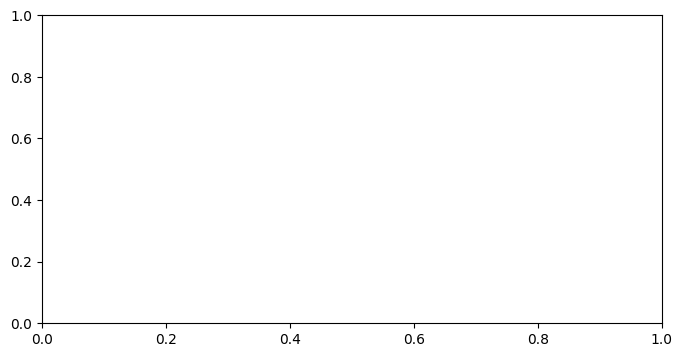

In [ ]:
# Tabel perbandingan
results_df = (
    pd.DataFrame({
        'Macro F1-Score': pd.Series(results),
        'Accuracy': pd.Series(accuracy_results)
    })
    .sort_values('Macro F1-Score', ascending=False)
)
print(results_df.to_string())

# Bar chart
plt.figure(figsize=(8, 4))
results_df['Macro F1-Score'].plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Macro F1-Score')
plt.title('Perbandingan Macro F1-Score Semua Model')
plt.xlim(0, 1)
for i, v in enumerate(results_df['Macro F1-Score']):
    plt.text(v + 0.005, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.show()


**Kesimpulan Perbandingan:**  
*[Model mana yang terbaik dan mengapa? Apa trade-off antara akurasi, kecepatan training, dan interpretabilitas?]*

---
## 4. Error Analysis

> **Tujuan:** Memahami pola kegagalan model dan menemukan peluang perbaikan.

### 4.1 Confusion Matrix

In [ ]:
best_model_name = max(results, key=results.get)
best_estimator = model_registry[best_model_name]
y_pred_best = cv_details[best_model_name]['oof_pred']

best_model = clone(best_estimator)

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_train, y_pred_best),
    display_labels=['Rejected (0)', 'Approved (1)']
).plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f'Confusion Matrix - {best_model_name} (OOF)')
plt.tight_layout()
plt.show()


**Analisis Confusion Matrix:**  
*[Berapa FP dan FN? Dalam konteks loan approval, mana yang lebih merugikan: FP (approve yang seharusnya ditolak) atau FN (tolak yang seharusnya diapprove)?]*

### 4.2 Analisis Sampel yang Salah Diklasifikasikan

In [ ]:
# Snippet: membuat dataframe error
# -------------------------------------------------------
# y_val_arr  = y_val.reset_index(drop=True)
# X_val_arr  = X_val.reset_index(drop=True)
# pred_arr   = pd.Series(y_pred_best, name='y_pred')
#
# error_mask = y_val_arr != pred_arr
# error_df = X_val_arr[error_mask].copy()
# error_df['y_true'] = y_val_arr[error_mask].values
# error_df['y_pred'] = pred_arr[error_mask].values
#
# print(f"Total error: {len(error_df)} / {len(y_val)} sampel ({len(error_df)/len(y_val)*100:.1f}%)")
# -------------------------------------------------------

y_true_arr = y_train.reset_index(drop=True)
X_arr = X_train.reset_index(drop=True)
pred_arr = pd.Series(y_pred_best, name='y_pred')

error_mask = y_true_arr != pred_arr
error_df = X_arr[error_mask].copy()
error_df['y_true'] = y_true_arr[error_mask].values
error_df['y_pred'] = pred_arr[error_mask].values

print(f"Total error: {len(error_df)} / {len(y_train)} sampel ({len(error_df)/len(y_train)*100:.1f}%)")
error_df.head(10)


### 4.3 Feature Importance

In [ ]:
# Snippet: feature importance dari tree-based model
# -------------------------------------------------------
# model_with_fi = rf_model  # atau gb_model
#
# importance_df = pd.DataFrame({
#     'Feature':    X_train.columns,
#     'Importance': model_with_fi.feature_importances_
# }).sort_values('Importance', ascending=False)
#
# plt.figure(figsize=(8, 5))
# sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
# plt.title('Feature Importance')
# plt.tight_layout()
# plt.show()
# -------------------------------------------------------

X_train_fi = handle_outliers(X_train.copy(), is_test=False, method=OUTLIER_METHOD, z_thresh=OUTLIER_Z_THRESH)
X_train_fi = encode_features(X_train_fi, is_test=False)

train_median = X_train_fi.median(numeric_only=True)
X_train_fi = X_train_fi.fillna(train_median)

best_model.fit(X_train_fi, y_train)
model_with_fi = best_model

if hasattr(model_with_fi, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': X_train_fi.columns,
        'Importance': model_with_fi.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
    plt.title('Top 10 Feature Importance')
    plt.tight_layout()
    plt.show()

    importance_df.head(10)
else:
    print(f"Model {best_model_name} tidak punya attribute feature_importances_.")


**Analisis Feature Importance:**  
*[Fitur mana paling berpengaruh? Apakah masuk akal secara bisnis? Ada fitur dengan importance sangat rendah yang bisa dihapus?]*

### 4.4 Kesimpulan Error Analysis

*[Ringkaskan temuan. Apa perbaikan yang bisa dilakukan pada iterasi berikutnya?]*

---
## 5. Submisi Kaggle

> ⚠️ **PENTING:**
> - Jangan gunakan `sample_submission.csv` sebagai submisi utama.
> - Pastikan hasil prediksi **reproducible** dari notebook ini.
> - Format: kolom `person_id` dan `loan_status`.

In [ ]:
# Gunakan seluruh data train (100%) untuk training final
X_train_full = X_all.copy()
y_train_full = y_all.copy()

X_train_final = handle_outliers(X_train_full.copy(), is_test=False, method=OUTLIER_METHOD, z_thresh=OUTLIER_Z_THRESH)
X_train_final = encode_features(X_train_final, is_test=False)

X_test_processed = handle_outliers(X_test_final.copy(), is_test=True, method=OUTLIER_METHOD, z_thresh=OUTLIER_Z_THRESH)
X_test_processed = encode_features(X_test_processed, is_test=True)

# train_median = X_train_final.median(numeric_only=True)
# X_train_final = X_train_final.fillna(train_median)
# X_test_processed = X_test_processed.fillna(train_median)

final_model = clone(model_registry[best_model_name])

final_model.fit(X_train_final, y_train_full)
test_predictions = final_model.predict(X_test_processed)

submission = pd.DataFrame({
    'person_id': test_df[ID_COL],
    'loan_status': test_predictions
})

submission.to_csv('submission.csv', index=False)
print(f"Train full shape: {X_train_full.shape} | Test shape: {X_test_final.shape}")
print(f"Saved! Shape: {submission.shape}")
print("Distribusi prediksi:")
print(submission['loan_status'].value_counts())
submission.head(10)


**Catatan Submisi:**
| | |
|---|---|
| Model final | *[nama model]* |
| Macro F1 — Validation Set | *[isi]* |
| Macro F1 — Kaggle Public LB | *[isi setelah submit]* |
| Macro F1 — Kaggle Private LB | *[isi setelah submit]* |

---
## 6. Kesimpulan Keseluruhan

*[Tuliskan kesimpulan: model terbaik, insight dari EDA, temuan error analysis, dan apa yang bisa ditingkatkan.]*